#### Globals

In [1]:
#   IMAGE_PATH, ROI, ANNOTATION_PATH, OUTPUT_DIR
#IMAGE_PATH = "./images/ncr_8338d_mcmaster_mz_mit20x2.jpg"       
IMAGE_PATH = "./images/die_flat.jpg"
ROI = (2112, 2400, 7600, 5740)  # <-- EDIT to your test region
ANNOTATION_PATH = "./mioc_annotated_netlist.txt" 
OUTPUT_DIR = "./output-metal-corner-detect"
TEMPLATE_PATHS = ["./input-metal-corner-detect/NE_1.png",
                  "./input-metal-corner-detect/SE_1.png",
                  "./input-metal-corner-detect/NW_1.png",
                  "./input-metal-corner-detect/SW_1.png"
                  ]
#(any filenames ok; sizes can vary; apex assumed at template center)

#### Simple color based metal extract (near white s filtered out via raster scan)

/home/ediaz/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Filtered image saved to ./output-metal-corner-detect/./turns_metal_mask.png


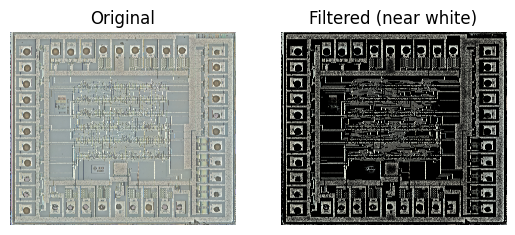

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Make directory if it doesnt exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Remove all files in OUTPUT_DIR ---
for fname in os.listdir(OUTPUT_DIR):
    fpath = os.path.join(OUTPUT_DIR, fname)
    if os.path.isfile(fpath):
        os.remove(fpath)

# --- Global directories ---
#INPUT_DIR = "input"   # change to your input dir
#OUTPUT_DIR = "output" # change to your output dir

# --- Parameters ---
tol = 80               # tolerance around white

input_path = IMAGE_PATH
output_path = os.path.join(OUTPUT_DIR, "./turns_metal_mask.png")

# --- Load image ---
img = cv2.imread(input_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- Define white band ---
lower = np.array([255 - tol, 255 - tol, 255 - tol])
upper = np.array([255, 255, 255])

# --- Mask pixels within band ---
mask = cv2.inRange(img_rgb, lower, upper)

# --- Apply mask ---
filtered = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)

# --- Save filtered image ---
cv2.imwrite(output_path, cv2.cvtColor(filtered, cv2.COLOR_RGB2BGR))
print(f"Filtered image saved to {output_path}")

# --- Optional: show results ---
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Filtered (near white)")
plt.imshow(filtered)
plt.axis("off")
plt.show()


#### Add via-contacts to metal mask so "turns into a contact" can be detected.
##### This creates contacts as white rectangles, so that a turn can be better detected

Contacts CSV: ./output-metal-via-contacts/mioc_roi_merge_detections_merged.csv
Metal in:     output-metal-corner-detect/turns_metal_mask.png
Merged out:   output-metal-corner-detect/turns_metal_mask_plus_contacts.png
Image shape:  (10515, 12271)
Contacts rasterized: total=975, vertical=409, horizontal=566
Defaults used (if w/h missing): V=15x60, H=60x15, pad=1px
METAL_MASK_PATH updated -> output-metal-corner-detect/turns_metal_mask_plus_contacts.png


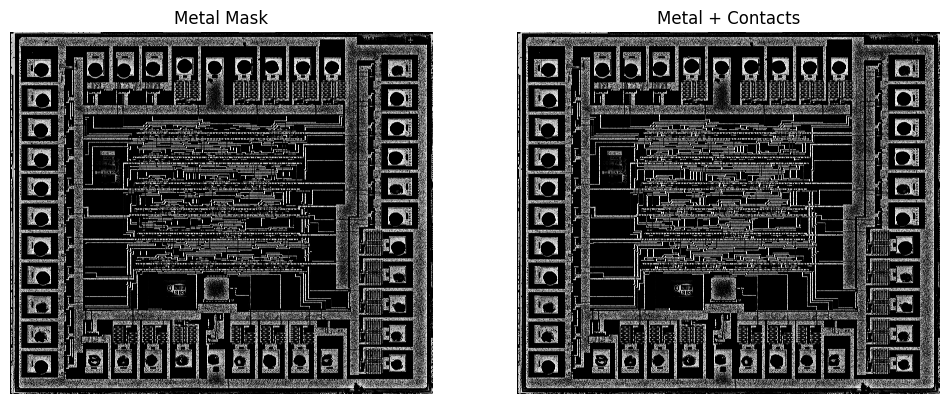

In [8]:
# --- Cell: Merge H/V contacts into METAL MASK as white rectangles ---

import os
import csv
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Globals expected:
# OUTPUT_DIR, (optional) CONTACTS_CSV
# Metal mask from your earlier cell:
METAL_IN_PATH  = str(Path(OUTPUT_DIR) / "turns_metal_mask.png")
METAL_OUT_PATH = str(Path(OUTPUT_DIR) / "turns_metal_mask_plus_contacts.png")

# ---- Configure contact source & defaults ----
# CSV columns expected:
#   x_center|xc|x , y_center|yc|y , orientation|orient|dir|direction (values: vertical|V or horizontal|H)
# Optional per-contact sizes (pixels): w|width , h|height
#CONTACTS_CSV   = globals().get("CONTACTS_CSV", "./out-turns/contacts.csv")
#CONTACTS_CSV   = globals().get("CONTACTS_CSV", "./output-metal-via-contacts/mioc_roi_merge_detections_merged.csv")
CONTACTS_CSV   = "./output-metal-via-contacts/mioc_roi_merge_detections_merged.csv"

# Default sizes if w/h not provided (axis-aligned):
#   Vertical   = 30x60  (w x h)
#   Horizontal = 60x30
DEFAULT_V_W, DEFAULT_V_H = 15, 60
DEFAULT_H_W, DEFAULT_H_H = 60, 15

# Optional connectivity pad (expands each rectangle by this many pixels on all sides; 0 disables)
CONTACT_PAD = 1  # try 0–2

# ---- Load metal mask ----
metal = cv2.imread(METAL_IN_PATH, cv2.IMREAD_UNCHANGED)
if metal is None:
    raise FileNotFoundError(f"Could not read metal mask at: {METAL_IN_PATH}")
metal_gray = cv2.cvtColor(metal, cv2.COLOR_BGR2GRAY) if metal.ndim == 3 else metal
H, W = metal_gray.shape

# ---- Build empty contact mask ----
contact_mask = np.zeros((H, W), dtype=np.uint8)

def pick_key(cols, candidates):
    for k in candidates:
        if k in cols: return k
    return None

# ---- Rasterize contacts from CSV as filled white rectangles ----
count_total = count_v = count_h = 0
with open(CONTACTS_CSV, newline="") as f:
    reader = csv.DictReader(f)
    # normalize header keys (preserve original for indexing)
    cols = {k.strip(): k for k in reader.fieldnames}

    kx  = pick_key(cols, ["x_center","xc","x","X_CENTER","X"])
    ky  = pick_key(cols, ["y_center","yc","y","Y_CENTER","Y"])
    ko  = pick_key(cols, ["orientation","orient","dir","direction","o","O"])
    kw  = pick_key(cols, ["w","width","W","WIDTH"])
    kh  = pick_key(cols, ["h","height","H","HEIGHT"])

    if not (kx and ky and ko):
        raise ValueError(f"CSV must contain x/y/orientation columns. Found: {reader.fieldnames}")

    for row in reader:
        try:
            cx = int(round(float(row[cols[kx]])))
            cy = int(round(float(row[cols[ky]])))
        except Exception:
            continue

        ori_raw = str(row[cols[ko]]).strip().lower()
        if ori_raw in ("v","vert","vertical"):
            ori = "vertical"
            w_box =  DEFAULT_V_W
            h_box =  DEFAULT_V_H
            count_v += 1
        elif ori_raw in ("h","hor","horiz","horizontal"):
            ori = "horizontal"
            w_box =  DEFAULT_H_W
            h_box =  DEFAULT_H_H
            count_h += 1
        else:
            # unknown orientation label; skip
            continue

        # Optional pad
        w_box = max(1, w_box + 2*CONTACT_PAD)
        h_box = max(1, h_box + 2*CONTACT_PAD)

        # Compute box bounds centered at (cx, cy)
        half_w = w_box // 2
        half_h = h_box // 2
        x0 = max(0, cx - half_w)
        y0 = max(0, cy - half_h)
        # For even sizes, ensure requested extent by using exclusive end index
        x1 = min(W, cx + half_w + (0 if (w_box % 2) == 1 else 0))
        y1 = min(H, cy + half_h + (0 if (h_box % 2) == 1 else 0))

        if x0 < x1 and y0 < y1:
            contact_mask[y0:y1, x0:x1] = 255
            count_total += 1

# ---- Union contacts with metal mask ----
metal_plus = np.maximum(metal_gray, contact_mask)

# ---- Save merged mask & update global path for downstream detection ----
os.makedirs(OUTPUT_DIR, exist_ok=True)
cv2.imwrite(METAL_OUT_PATH, metal_plus)
METAL_MASK_PATH = METAL_OUT_PATH  # downstream cells that use this global will pick up the merged mask

print(f"Contacts CSV: {CONTACTS_CSV}")
print(f"Metal in:     {METAL_IN_PATH}")
print(f"Merged out:   {METAL_OUT_PATH}")
print(f"Image shape:  {(H, W)}")
print(f"Contacts rasterized: total={count_total}, vertical={count_v}, horizontal={count_h}")
print(f"Defaults used (if w/h missing): V={DEFAULT_V_W}x{DEFAULT_V_H}, H={DEFAULT_H_W}x{DEFAULT_H_H}, pad={CONTACT_PAD}px")
print("METAL_MASK_PATH updated ->", METAL_MASK_PATH)

# ---- Quick preview (optional) ----
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.title("Metal Mask"); plt.imshow(metal_gray, cmap="gray"); plt.axis("off")
plt.subplot(1,2,2); plt.title("Metal + Contacts"); plt.imshow(metal_plus, cmap="gray"); plt.axis("off")
plt.show()


#### Corner detection using correlation to sample images, ./input-metal-cornet-corner-detect
##### - Added white fraction detector to eliminate "squiggles"

Image shape (H, W): (10515, 12271)
ROI (x, y, w, h): (2112, 2400, 7600, 5740)
ROI (xmin, ymin, xmax, ymax): (2112, 2400, 9712, 8140)
Detections (after white-fraction gate ≥ 0.20): 729
Saved: output-metal-corner-detect/corners_metal_57.csv
Saved overlay: output-metal-corner-detect/corners_on_metal_57.png


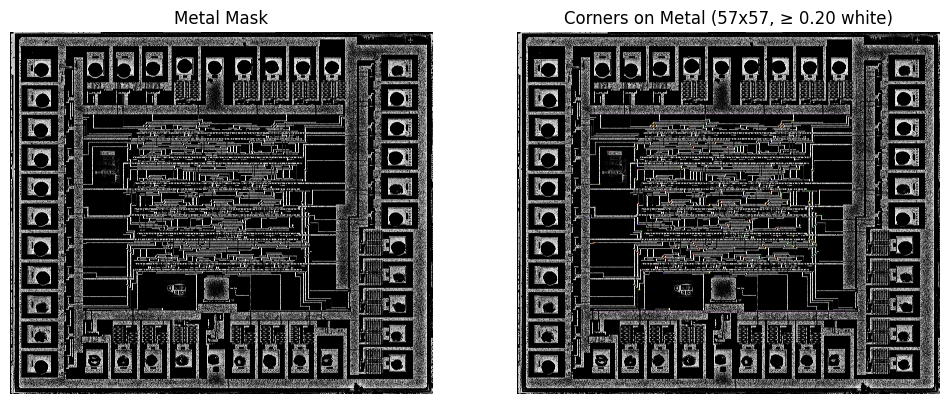

In [6]:
# --- Corner detection on METAL MASK (57x57) + tile white-fraction gate ---

import os, csv
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Globals:
# IMAGE_PATH, ROI, OUTPUT_DIR, TEMPLATE_PATHS
# ROI is (x, y, width, height)
METAL_MASK_PATH = os.path.join(OUTPUT_DIR, "turns_metal_mask_plus_contacts.png")

# ---- Config ----
BOX_SIZE    = 57
THRESH      = 0.80
NMS_RADIUS  = 16
MIN_WHITE_FRACTION = 0.20   # <- new: require at least this fraction of white per tile
BOX_COLORS  = {"NW":(255,0,0), "NE":(0,255,0), "SW":(0,0,255), "SE":(255,255,0)}

def roi_xywh_to_xyxy(roi_xywh, img_w, img_h):
    x, y, w, h = roi_xywh
    xmin = int(max(0, x)); ymin = int(max(0, y))
    xmax = int(min(img_w, x + w)); ymax = int(min(img_h, y + h))
    return xmin, ymin, xmax, ymax

def infer_corner_type(path):
    name = Path(path).name.upper()
    for k in ("NW","NE","SW","SE"):
        if k in name: return k
    raise ValueError(f"Cannot infer corner type from template filename: {path}")

def load_template_57(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: raise FileNotFoundError(f"Template not found: {path}")
    g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim==3 else img
    g = cv2.normalize(g, None, 0, 255, cv2.NORM_MINMAX)
    _, gb = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    gb = cv2.resize(gb, (BOX_SIZE, BOX_SIZE), interpolation=cv2.INTER_AREA).astype(np.float32)
    tpl_inv = cv2.bitwise_not(gb.astype(np.uint8))
    tpl_dt  = cv2.distanceTransform(tpl_inv, cv2.DIST_L2, 3)
    tpl_dt  = cv2.normalize(tpl_dt, None, 0, 255, cv2.NORM_MINMAX).astype(np.float32)
    return gb, tpl_dt

# ---- Load metal mask ----
metal = cv2.imread(METAL_MASK_PATH, cv2.IMREAD_UNCHANGED)
if metal is None: raise FileNotFoundError(f"Could not read metal mask: {METAL_MASK_PATH}")
metal_gray = cv2.cvtColor(metal, cv2.COLOR_BGR2GRAY) if metal.ndim==3 else metal
H, W = metal_gray.shape

# Binary (for matching) + distance transform
_, metal_bin = cv2.threshold(metal_gray, 1, 255, cv2.THRESH_BINARY)
metal_inv = cv2.bitwise_not(metal_bin)
metal_dt  = cv2.distanceTransform(metal_inv, cv2.DIST_L2, 3)
metal_dt  = cv2.normalize(metal_dt, None, 0, 255, cv2.NORM_MINMAX).astype(np.float32)

# Extra binary (0/1) for white-fraction test
metal01 = (metal_gray > 0).astype(np.uint8)

# ---- ROI ----
x, y, w, h = ROI
xmin, ymin, xmax, ymax = roi_xywh_to_xyxy((x, y, w, h), W, H)
print("Image shape (H, W):", (H, W))
print("ROI (x, y, w, h):", (x, y, w, h))
print("ROI (xmin, ymin, xmax, ymax):", (xmin, ymin, xmax, ymax))

# ---- Templates ----
templates = []
for tpath in TEMPLATE_PATHS:
    ctype = infer_corner_type(tpath)
    tpl_bin, tpl_dt = load_template_57(tpath)
    templates.append((ctype, tpl_bin, tpl_dt, Path(tpath).name))

# ---- Pad-safe crop around ROI ----
pad = BOX_SIZE // 2
sx0 = max(0, xmin - pad); sy0 = max(0, ymin - pad)
sx1 = min(W, xmax + pad); sy1 = min(H, ymax + pad)

crop_bin = metal_bin[sy0:sy1, sx0:sx1].astype(np.float32)
crop_dt  = metal_dt [sy0:sy1, sx0:sx1].astype(np.float32)

# ---- Fast local-maximum NMS via dilation ----
K = 2 * NMS_RADIUS + 1
kernel = np.ones((K, K), np.uint8)
detections = []

for (ctype, tpl_bin, tpl_dt, tpl_name) in templates:
    res_bin = cv2.matchTemplate(crop_bin, tpl_bin, cv2.TM_CCOEFF_NORMED)
    res_dt  = cv2.matchTemplate(crop_dt,  tpl_dt,  cv2.TM_CCOEFF_NORMED)
    res     = np.maximum(res_bin, res_dt)

    mask = res >= THRESH
    if not np.any(mask): continue

    res_max = cv2.dilate(res, kernel)
    peaks = mask & (res == res_max)

    ys, xs = np.where(peaks)
    for yy, xx in zip(ys, xs):
        tl_x = sx0 + xx
        tl_y = sy0 + yy
        cx   = tl_x + BOX_SIZE // 2
        cy   = tl_y + BOX_SIZE // 2

        if not ((xmin <= cx < xmax) and (ymin <= cy < ymax)):
            continue

        # --- NEW: tile white-fraction gate ---
        x0 = cx - BOX_SIZE//2; y0 = cy - BOX_SIZE//2
        x1 = x0 + BOX_SIZE;    y1 = y0 + BOX_SIZE
        if x0 < 0 or y0 < 0 or x1 > W or y1 > H:
            continue
        tile_white = metal01[y0:y1, x0:x1].sum() / float(BOX_SIZE * BOX_SIZE)
        if tile_white < MIN_WHITE_FRACTION:
            continue
        # -------------------------------------

        detections.append((cx, cy, float(res[yy, xx]), ctype, tpl_name))

print(f"Detections (after white-fraction gate ≥ {MIN_WHITE_FRACTION:.2f}): {len(detections)}")

# ---- Save CSV ----
csv_path = Path(OUTPUT_DIR) / "corners_metal_57.csv"
with open(csv_path, "w", newline="") as f:
    wcsv = csv.writer(f)
    wcsv.writerow(["x_center","y_center","score","corner_type","template"])
    for d in detections: wcsv.writerow(d)
print(f"Saved: {csv_path}")

# ---- Draw rectangles on METAL MASK ----
overlay_rgb = cv2.cvtColor(metal_gray, cv2.COLOR_GRAY2RGB)
for (cx, cy, score, ctype, tplname) in detections:
    x0, y0 = cx - BOX_SIZE//2, cy - BOX_SIZE//2
    x1, y1 = x0 + BOX_SIZE - 1, y0 + BOX_SIZE - 1
    color = BOX_COLORS.get(ctype, (255,255,255))
    cv2.rectangle(overlay_rgb, (x0, y0), (x1, y1), color, 1)

cv2.rectangle(overlay_rgb, (xmin, ymin), (xmax-1, ymax-1), (255, 0, 255), 2)
out_img = Path(OUTPUT_DIR) / "corners_on_metal_57.png"
cv2.imwrite(str(out_img), cv2.cvtColor(overlay_rgb, cv2.COLOR_RGB2BGR))
print(f"Saved overlay: {out_img}")

# ---- Preview (optional) ----
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.title("Metal Mask"); plt.imshow(metal_gray, cmap="gray"); plt.axis("off")
plt.subplot(1,2,2); plt.title(f"Corners on Metal (57x57, ≥ {MIN_WHITE_FRACTION:.2f} white)"); plt.imshow(overlay_rgb); plt.axis("off")
plt.show()


#### Full overlay plus variable box thickness

Loaded detections: 729 from corners_metal_57.csv
Saved overlay: output-metal-corner-detect/overlay_full_original.png


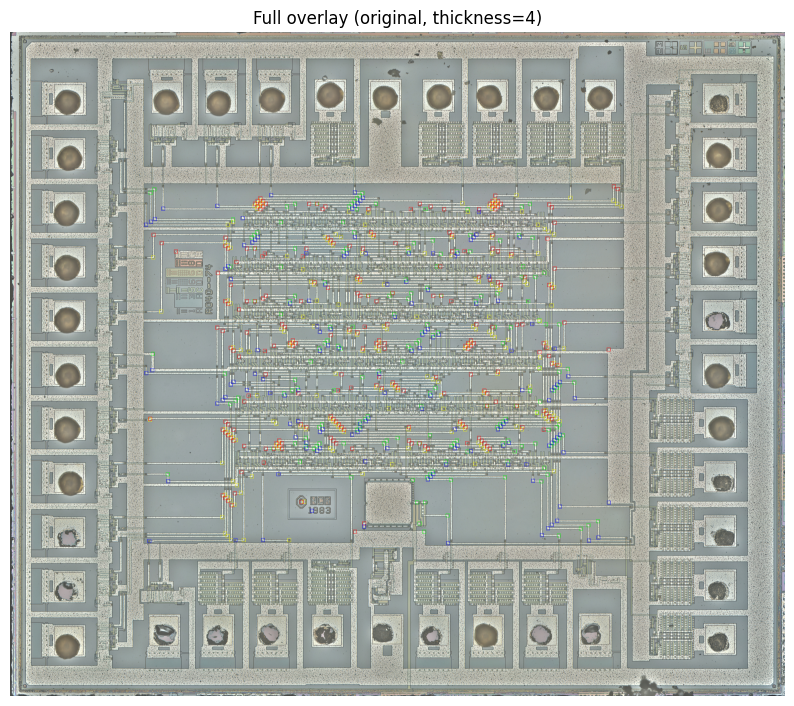

In [7]:
# --- Cell: Full overlay of detected corners with uniform box thickness ---

import os, csv
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Globals expected:
# IMAGE_PATH, OUTPUT_DIR, (optional) BOX_SIZE, METAL_MASK_PATH
CSV_IN = Path(OUTPUT_DIR) / "corners_metal_57.csv"

# Choose background: "original" or "metal"
BACKGROUND = "original"   # <- set to "metal" if you want to draw on the metal mask

# Uniform thickness for all boxes
LINE_THICKNESS = 4        # <- your single thickness knob

# Corner box size (defaults to 57 if not defined earlier)
BOX_SIZE = int(globals().get("BOX_SIZE", 57))

# Colors per corner type (RGB)
BOX_COLORS = {"NW": (255, 0, 0), "NE": (0, 255, 0), "SW": (0, 0, 255), "SE": (255, 255, 0)}

# --- Load background image ---
if BACKGROUND.lower().startswith("metal"):
    # Use metal mask (with contacts if you've set METAL_MASK_PATH to that file)
    bg_path = globals().get("METAL_MASK_PATH", str(Path(OUTPUT_DIR) / "turns_metal_mask.png"))
    bg = cv2.imread(bg_path, cv2.IMREAD_UNCHANGED)
    if bg is None:
        raise FileNotFoundError(f"Could not read metal background at: {bg_path}")
    if bg.ndim == 2:
        bg_rgb = cv2.cvtColor(bg, cv2.COLOR_GRAY2RGB)
    else:
        bg_rgb = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)
    out_name = "overlay_full_metal.png"
else:
    # Use original image
    bg = cv2.imread(IMAGE_PATH, cv2.IMREAD_UNCHANGED)
    if bg is None:
        raise FileNotFoundError(f"Could not read IMAGE_PATH: {IMAGE_PATH}")
    bg_rgb = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB) if bg.ndim == 3 else cv2.cvtColor(bg, cv2.COLOR_GRAY2RGB)
    out_name = "overlay_full_original.png"

H, W = bg_rgb.shape[:2]

# --- Load detections ---
rows = []
with open(CSV_IN, newline="") as f:
    r = csv.DictReader(f)
    for row in r:
        rows.append(row)

print(f"Loaded detections: {len(rows)} from {CSV_IN.name}")

# --- Draw boxes ---
half = BOX_SIZE // 2
overlay = bg_rgb.copy()

for row in rows:
    try:
        cx = int(round(float(row["x_center"])))
        cy = int(round(float(row["y_center"])))
    except Exception:
        continue

    x0, y0 = cx - half, cy - half
    x1, y1 = x0 + BOX_SIZE - 1, y0 + BOX_SIZE - 1
    # Clamp to image bounds (skip if largely outside)
    if x1 < 0 or y1 < 0 or x0 >= W or y0 >= H:
        continue
    x0 = max(0, x0); y0 = max(0, y0); x1 = min(W - 1, x1); y1 = min(H - 1, y1)

    ctype = str(row.get("corner_type", "")).upper()
    color = BOX_COLORS.get(ctype, (255, 255, 255))
    cv2.rectangle(overlay, (x0, y0), (x1, y1), color, LINE_THICKNESS)

# --- Save & quick preview ---
out_path = Path(OUTPUT_DIR) / out_name
cv2.imwrite(str(out_path), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
print(f"Saved overlay: {out_path}")

plt.figure(figsize=(10,10))
plt.title(f"Full overlay ({BACKGROUND}, thickness={LINE_THICKNESS})")
plt.imshow(overlay); plt.axis("off"); plt.show()


#### Merge missed turns

In [ ]:
# --- Merge missed turns into detected corners & write *_final outputs ---------------------------
# USER INPUTS (uncomment & edit as needed):
MISSED_TURNS = [(3980, 4250, "N"), (123, 456, "NE")]   # list of (x, y, direction). Direction is free-form (e.g., N,E,S,W,NE,NW,SE,SW)
OUTPUT_DIR = "/output-metal-corner-detect"   # if not already defined above in the notebook
INPUT_CSV_NAME = "corners_metal_57.csv"               # existing detections CSV inside OUTPUT_DIR
# BACKGROUND_IMAGE_PATH = "/path/to/background.png"     # OPTIONAL: if set, create an overlay image using this background
# DEDUP_TOL = 0                                         # OPTIONAL: tolerance in pixels when deduplicating (0 = exact x,y match)
# OVERLAY_POINT_RADIUS = 6                              # OPTIONAL: point marker radius (cv2)
# OVERLAY_POINT_THICKNESS = 2                           # OPTIONAL: point marker thickness (cv2)
# LABEL_FONT_SCALE = 0.4                                # OPTIONAL: label font size
LABEL_THICKNESS = 4                                   # OPTIONAL: label thickness

import os
import math
import pandas as pd
import numpy as np

# Try OpenCV for overlay; if unavailable, we'll skip overlay gracefully
try:
    import cv2
    _HAS_CV2 = True
except Exception:
    _HAS_CV2 = False

# ---------- Resolve inputs & defaults ----------
# If these variables are already defined earlier in your notebook, we respect them.
MISSED_TURNS = globals().get("MISSED_TURNS", [])
OUTPUT_DIR = globals().get("OUTPUT_DIR", os.getcwd())
INPUT_CSV_NAME = globals().get("INPUT_CSV_NAME", "corners_metal_57.csv")
BACKGROUND_IMAGE_PATH = globals().get("BACKGROUND_IMAGE_PATH", None)
DEDUP_TOL = globals().get("DEDUP_TOL", 0)
OVERLAY_POINT_RADIUS = globals().get("OVERLAY_POINT_RADIUS", 6)
OVERLAY_POINT_THICKNESS = globals().get("OVERLAY_POINT_THICKNESS", 2)
LABEL_FONT_SCALE = globals().get("LABEL_FONT_SCALE", 0.4)
LABEL_THICKNESS = globals().get("LABEL_THICKNESS", 1)

os.makedirs(OUTPUT_DIR, exist_ok=True)
input_csv_path = os.path.join(OUTPUT_DIR, INPUT_CSV_NAME)

if not os.path.isfile(input_csv_path):
    raise FileNotFoundError(f"Input CSV not found: {input_csv_path}")

base_csv_name, ext = os.path.splitext(INPUT_CSV_NAME)
final_csv_name = f"{base_csv_name}_final.csv"
final_csv_path = os.path.join(OUTPUT_DIR, final_csv_name)

# ---------- Load existing detections ----------
df_in = pd.read_csv(input_csv_path)

# Ensure required columns exist, or create them
if "x_center" not in df_in.columns or "y_center" not in df_in.columns:
    raise ValueError("Input CSV must contain 'x_center' and 'y_center' columns.")

# Corner/turn direction column; if absent, we’ll create one with 'unknown'
if "corner_type" not in df_in.columns:
    df_in["corner_type"] = "unknown"

# Add 'source' tag for provenance
if "source" not in df_in.columns:
    df_in["source"] = "detected"
else:
    df_in["source"] = df_in["source"].fillna("detected")

# ---------- Prepare manual/missed turns ----------
def _normalize_direction(s):
    if not isinstance(s, str):
        return "unknown"
    s = s.strip().upper()
    return s if s else "unknown"

def _to_int(v):
    # Be robust if floats sneak in
    try:
        return int(round(float(v)))
    except Exception:
        return v

manual_records = []
for tup in MISSED_TURNS:
    if not isinstance(tup, (list, tuple)) or len(tup) < 3:
        # Skip invalid entries silently
        continue
    x, y, d = tup[0], tup[1], tup[2]
    manual_records.append(
        {
            "x_center": _to_int(x),
            "y_center": _to_int(y),
            "corner_type": _normalize_direction(d),
            "source": "manual"
        }
    )

df_manual = pd.DataFrame(manual_records) if manual_records else pd.DataFrame(columns=["x_center","y_center","corner_type","source"])

# Ensure df_manual has all columns present in df_in so we preserve structure
for col in df_in.columns:
    if col not in df_manual.columns:
        df_manual[col] = np.nan

# Reorder to match df_in
df_manual = df_manual[df_in.columns]

# ---------- Concatenate & de-duplicate ----------
df_all = pd.concat([df_in, df_manual], ignore_index=True)

def _dedup_with_tolerance(df, tol):
    """
    Drops duplicates using (x_center, y_center).
    If tol == 0: exact match.
    If tol > 0: round to nearest tol grid for grouping.
    Keeps the first occurrence (detected rows will generally come first; manual second).
    """
    if tol and tol > 0:
        # Create grouped keys by rounding to a tolerance grid
        xk = (df["x_center"].astype(float) / tol).round().astype(int)
        yk = (df["y_center"].astype(float) / tol).round().astype(int)
        key = xk.astype(str) + "_" + yk.astype(str)
        keep_mask = ~key.duplicated(keep="first")
        return df.loc[keep_mask].copy()
    else:
        return df.drop_duplicates(subset=["x_center","y_center"], keep="first").copy()

df_final = _dedup_with_tolerance(df_all, DEDUP_TOL)

# ---------- Save merged CSV with _final suffix ----------
df_final.to_csv(final_csv_path, index=False)

print(f"[OK] Merged CSV written: {final_csv_path}")
print(f" - Detected rows: {len(df_in)}")
print(f" - Manual rows provided: {len(df_manual)}")
print(f" - Final rows after dedup: {len(df_final)}")

# ---------- Optional overlay generation ----------
def _draw_overlay_cv2(bg_path, df_points, out_dir):
    if not _HAS_CV2:
        print("[WARN] OpenCV (cv2) not available; skipping overlay.")
        return None

    img = cv2.imread(bg_path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"[WARN] Could not read background image: {bg_path} — skipping overlay.")
        return None

    # Simple color map by direction; unknown/default gets magenta
    COLOR_MAP = {
        "NE": (0, 0, 255),
        "NW": (0, 255, 0),
        "SE": (255, 0, 0),
        "SW": (255, 255, 0),
        "N":  (255, 0, 255),
        "S":  (255, 0, 255),
        "E":  (255, 0, 255),
        "W":  (255, 0, 255),
        "UNKNOWN": (255, 0, 255)
    }

    for _, row in df_points.iterrows():
        try:
            x = int(round(float(row["x_center"])))
            y = int(round(float(row["y_center"])))
        except Exception:
            continue

        dir_str = _normalize_direction(row.get("corner_type", "unknown"))
        color = COLOR_MAP.get(dir_str, COLOR_MAP["UNKNOWN"])

        # draw point
        cv2.circle(img, (x, y), OVERLAY_POINT_RADIUS, color, OVERLAY_POINT_THICKNESS, lineType=cv2.LINE_AA)

        # label with direction (small)
        cv2.putText(
            img,
            dir_str,
            (x + OVERLAY_POINT_RADIUS + 2, y - OVERLAY_POINT_RADIUS - 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            LABEL_FONT_SCALE,
            color,
            LABEL_THICKNESS,
            lineType=cv2.LINE_AA
        )

    base = os.path.splitext(os.path.basename(bg_path))[0]
    out_path = os.path.join(out_dir, f"{base}_final.png")
    cv2.imwrite(out_path, img)
    return out_path

overlay_out = None
if BACKGROUND_IMAGE_PATH:
    overlay_out = _draw_overlay_cv2(BACKGROUND_IMAGE_PATH, df_final, OUTPUT_DIR)
    if overlay_out:
        print(f"[OK] Overlay image written: {overlay_out}")
    else:
        print("[INFO] Overlay not produced.")
else:
    print("[INFO] BACKGROUND_IMAGE_PATH not set; only the merged CSV was produced.")
# -----------------------------------------------------------------------------------------------
